# LSTM + Word Embedding

In this model, we will use deep learning with word embedding to classify the tweet sentiment.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, cohen_kappa_score

import pickle

from timeit import default_timer as timer

from collections import Counter
from itertools import chain 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model

from custom_functions import clean_up, evaluating, scoring, get_pred

In [74]:
X_train = pd.read_pickle('PKL/X_train_fin.pkl')
X_val = pd.read_pickle('PKL/X_val_fin.pkl')
y_train = pd.read_csv('DATA/y_train.csv', index_col=0)
y_val = pd.read_csv('DATA/y_val.csv', index_col=0)

In [75]:
X_train = X_train['tweet']
X_val = X_val['tweet']

In [76]:
y_train = y_train['sentiment']
y_val = y_val['sentiment']

In [189]:
X_test = pd.read_pickle('PKL/X_test_fin.pkl')
y_test = pd.read_csv('DATA/y_test.csv', index_col=0)
X_test = X_test['tweet']
y_test = y_test['sentiment']

In [78]:
y_train.value_counts()

No emotion toward brand or product    2635
Positive emotion                      1547
Negative emotion                       306
Name: sentiment, dtype: int64

## Input Setup
---
First, tokenize the words and pad them to be equal lengths.

In [79]:
num_vocab = 4000

In [80]:
tokenizer = Tokenizer(num_words = num_vocab)
tokenizer.fit_on_texts(X_train)

In [81]:
# convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [82]:
# add padding
X_train_seq = pad_sequences(X_train_seq)
X_val_seq = pad_sequences(X_val_seq, maxlen=len(X_train_seq[0]))

In [83]:
max_len = len(X_train_seq[0])

In [84]:
# Converting target to be a binary array
y_train_ohe = pd.get_dummies(y_train)
y_train = y_train_ohe.values
classes = list(y_train_ohe.columns)
y_val = pd.get_dummies(y_val).values

## LSTM
Without pretrained model, let's run simple LSTM.

In [85]:
model = Sequential()
model.add(Embedding(num_vocab, 200, input_length = max_len))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [86]:
cb = EarlyStopping(monitor = 'val_loss', mode = 'min', 
                   verbose = 1, patience = 5, restore_best_weights = True)

start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 15s - loss: 0.8555 - categorical_accuracy: 0.5838 - val_loss: 0.8144 - val_categorical_accuracy: 0.6159
Epoch 2/100
141/141 - 5s - loss: 0.7084 - categorical_accuracy: 0.6816 - val_loss: 0.7860 - val_categorical_accuracy: 0.6346
Epoch 3/100
141/141 - 5s - loss: 0.5495 - categorical_accuracy: 0.7696 - val_loss: 0.8309 - val_categorical_accuracy: 0.6390
Epoch 4/100
141/141 - 7s - loss: 0.4117 - categorical_accuracy: 0.8362 - val_loss: 0.9723 - val_categorical_accuracy: 0.6373
Epoch 5/100
141/141 - 6s - loss: 0.3270 - categorical_accuracy: 0.8714 - val_loss: 1.1174 - val_categorical_accuracy: 0.6266
Epoch 6/100
141/141 - 5s - loss: 0.2577 - categorical_accuracy: 0.9033 - val_loss: 1.1204 - val_categorical_accuracy: 0.6373
Epoch 7/100
Restoring model weights from the end of the best epoch.
141/141 - 5s - loss: 0.2223 - categorical_accuracy: 0.9187 - val_loss: 1.3085 - val_categorical_accuracy: 0.6337
Epoch 00007: early stopping
Total Time Elapsed: 47.29700263900304


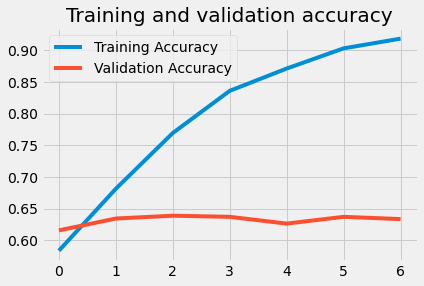

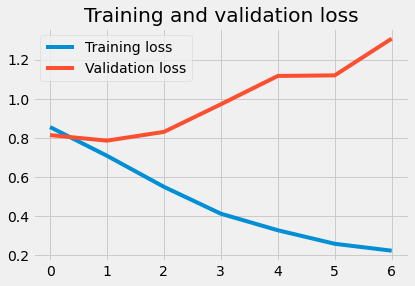

In [87]:
# plot performance
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch

    plt.plot(epochs, hist_['categorical_accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
    
plot_performance(history)

In [88]:
def change_to_classes(target):
    tmp = np.argmax(target, axis = 1)
    return np.where(tmp == 0, classes[0], 
        np.where(tmp == 1, classes[1], classes[2]))

def evaluate(model, X_val_seq, target):
    scores = model.evaluate(X_val_seq, target, verbose = 0)
    print('Loss:', round(scores[0], 4))
    print('Categorical Accuracy:', round(scores[1], 4))
    y_pred = model.predict(X_val_seq)
    y_val = change_to_classes(target)
    y_pred = change_to_classes(y_pred)
    print('Cohens Kappa', round(cohen_kappa_score(y_val, y_pred), 4))
    print(classification_report(y_val, y_pred))

In [89]:
evaluate(model, X_val_seq, y_val)

Loss: 0.786
Categorical Accuracy: 0.6346
Cohens Kappa 0.2273
                                    precision    recall  f1-score   support

                  Negative emotion       0.29      0.10      0.15        71
No emotion toward brand or product       0.67      0.85      0.75       666
                  Positive emotion       0.56      0.36      0.44       385

                          accuracy                           0.63      1122
                         macro avg       0.51      0.44      0.44      1122
                      weighted avg       0.61      0.63      0.60      1122



## LSTM Iter 2 - GloVe Twitter 200d
Now let's use pretrained workd embedding with GloVe. 

### GloVe
GloVe embeddings have pretrained data on twitter. I'll use that in the model.

In [90]:
from gensim.models import word2vec

In [27]:
# building GloVe dictionary
glove_path = '/Users/stereopickles/Documents/GloVe/glove.twitter.27B/glove.twitter.27B.200d.txt'
#glove_path_pc = 'D:\Projects\GloVe_Twitter\glove.twitter.27B.200d.txt'
glove_dict = {}
with open(glove_path, 'r', encoding = 'utf-8') as f:
    for line in f:
        vals = line.split(' ')
        glove_dict[vals[0]] = np.asarray(vals[1:], dtype = 'float32')

In [28]:
# save dictionary
#with open ('PKL/GloVe_dict.pkl', 'wb') as fp:
#    pickle.dump(glove_dict, fp)

In [91]:
with open('PKL/GloVe_dict.pkl', 'rb') as fp:
    glove_dict = pickle.load(fp)

In [92]:
# get embeddings for each word from the GloVe
word_emb_mat = np.zeros((num_vocab, 200))
for i in range(1, num_vocab):
    word = tokenizer.index_word[i]
    if word in glove_dict:
        word_emb_mat[i] = glove_dict[word]

In [93]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [94]:
start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 10s - loss: 0.8458 - categorical_accuracy: 0.5929 - val_loss: 0.7780 - val_categorical_accuracy: 0.6453
Epoch 2/100
141/141 - 5s - loss: 0.7527 - categorical_accuracy: 0.6569 - val_loss: 0.7447 - val_categorical_accuracy: 0.6836
Epoch 3/100
141/141 - 5s - loss: 0.6924 - categorical_accuracy: 0.6947 - val_loss: 0.7554 - val_categorical_accuracy: 0.6524
Epoch 4/100
141/141 - 5s - loss: 0.6235 - categorical_accuracy: 0.7246 - val_loss: 0.7570 - val_categorical_accuracy: 0.6684
Epoch 5/100
141/141 - 5s - loss: 0.5568 - categorical_accuracy: 0.7623 - val_loss: 0.8094 - val_categorical_accuracy: 0.6533
Epoch 6/100
141/141 - 7s - loss: 0.5001 - categorical_accuracy: 0.7910 - val_loss: 0.8190 - val_categorical_accuracy: 0.6471
Epoch 7/100
Restoring model weights from the end of the best epoch.
141/141 - 7s - loss: 0.4473 - categorical_accuracy: 0.8126 - val_loss: 0.8552 - val_categorical_accuracy: 0.6319
Epoch 00007: early stopping
Total Time Elapsed: 44.85322057200028


In [95]:
#model.save('MODEL/LSTM_v1.h5')

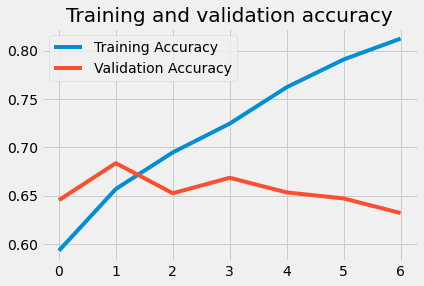

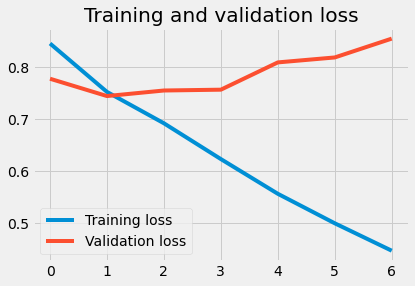

In [96]:
plot_performance(history)

In [97]:
evaluate(model, X_val_seq, y_val)

Loss: 0.7447
Categorical Accuracy: 0.6836
Cohens Kappa 0.3179
                                    precision    recall  f1-score   support

                  Negative emotion       0.27      0.04      0.07        71
No emotion toward brand or product       0.69      0.91      0.79       666
                  Positive emotion       0.67      0.41      0.51       385

                          accuracy                           0.68      1122
                         macro avg       0.55      0.45      0.46      1122
                      weighted avg       0.66      0.68      0.65      1122



Model is overall better but still not great. Let's try to add class weights.

## Iter 3 - Balanced Class Weight

### Calculating Weights

In [98]:
from sklearn.utils import class_weight

In [99]:
y = np.argmax(y_train, axis = 1)
cw = class_weight.compute_class_weight('balanced', np.unique(y), y)
cw = dict(zip(np.unique(y), cw))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[2 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [100]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [101]:
start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                    class_weight=cw,
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 13s - loss: 1.0347 - categorical_accuracy: 0.4349 - val_loss: 1.1028 - val_categorical_accuracy: 0.4287
Epoch 2/100
141/141 - 6s - loss: 0.9004 - categorical_accuracy: 0.5283 - val_loss: 0.9316 - val_categorical_accuracy: 0.5365
Epoch 3/100
141/141 - 5s - loss: 0.7911 - categorical_accuracy: 0.5804 - val_loss: 0.8736 - val_categorical_accuracy: 0.5642
Epoch 4/100
141/141 - 5s - loss: 0.6992 - categorical_accuracy: 0.6437 - val_loss: 0.8635 - val_categorical_accuracy: 0.5891
Epoch 5/100
141/141 - 6s - loss: 0.6206 - categorical_accuracy: 0.6805 - val_loss: 0.8301 - val_categorical_accuracy: 0.6141
Epoch 6/100
141/141 - 6s - loss: 0.5553 - categorical_accuracy: 0.7152 - val_loss: 0.8664 - val_categorical_accuracy: 0.6194
Epoch 7/100
141/141 - 6s - loss: 0.4995 - categorical_accuracy: 0.7393 - val_loss: 0.9371 - val_categorical_accuracy: 0.5900
Epoch 8/100
141/141 - 5s - loss: 0.4304 - categorical_accuracy: 0.7767 - val_loss: 0.9108 - val_categorical_accuracy: 0.6087

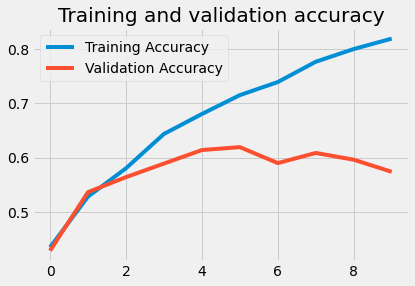

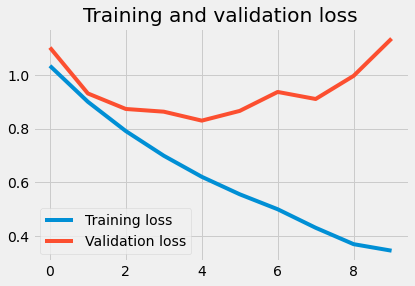

In [102]:
plot_performance(history)

In [103]:
evaluate(model, X_val_seq, y_val)

Loss: 0.8301
Categorical Accuracy: 0.6141
Cohens Kappa 0.3071
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.44      0.31        71
No emotion toward brand or product       0.73      0.66      0.69       666
                  Positive emotion       0.56      0.57      0.57       385

                          accuracy                           0.61      1122
                         macro avg       0.51      0.56      0.52      1122
                      weighted avg       0.64      0.61      0.63      1122



It improved the recall score of negative emotion but at the sacrifice of its precision and overall accuracy.

## Iteration 4 - More Dropout
Let's try to add more dropout to make this more generalizable.

In [113]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(Dropout(0.5))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [114]:
start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                    class_weight=cw,
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 9s - loss: 1.0615 - categorical_accuracy: 0.3935 - val_loss: 1.0142 - val_categorical_accuracy: 0.4893
Epoch 2/100
141/141 - 6s - loss: 0.9996 - categorical_accuracy: 0.4577 - val_loss: 0.9743 - val_categorical_accuracy: 0.5419
Epoch 3/100
141/141 - 6s - loss: 0.9250 - categorical_accuracy: 0.5038 - val_loss: 0.9468 - val_categorical_accuracy: 0.5401
Epoch 4/100
141/141 - 6s - loss: 0.8780 - categorical_accuracy: 0.5368 - val_loss: 0.8641 - val_categorical_accuracy: 0.5918
Epoch 5/100
141/141 - 6s - loss: 0.8542 - categorical_accuracy: 0.5448 - val_loss: 0.8816 - val_categorical_accuracy: 0.5615
Epoch 6/100
141/141 - 5s - loss: 0.7904 - categorical_accuracy: 0.5871 - val_loss: 0.8316 - val_categorical_accuracy: 0.5989
Epoch 7/100
141/141 - 5s - loss: 0.7585 - categorical_accuracy: 0.6107 - val_loss: 0.9128 - val_categorical_accuracy: 0.5722
Epoch 8/100
141/141 - 5s - loss: 0.6958 - categorical_accuracy: 0.6410 - val_loss: 0.8503 - val_categorical_accuracy: 0.6221


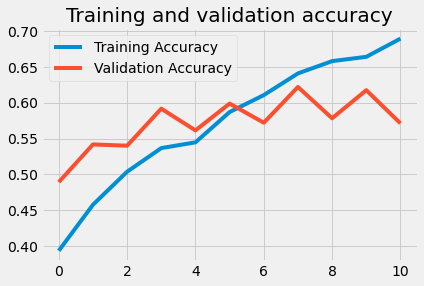

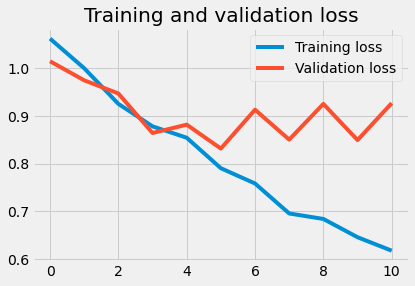

In [115]:
plot_performance(history)

In [116]:
evaluate(model, X_val_seq, y_val)

Loss: 0.8316
Categorical Accuracy: 0.5989
Cohens Kappa 0.2765
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.38      0.29        71
No emotion toward brand or product       0.72      0.64      0.68       666
                  Positive emotion       0.52      0.57      0.54       385

                          accuracy                           0.60      1122
                         macro avg       0.49      0.53      0.50      1122
                      weighted avg       0.62      0.60      0.61      1122



## Iteration 5 - Increase Learning Rate
Out training loss graph shows that our learning rate is too low. Let's try to increase that.

In [117]:
from tensorflow.keras import optimizers

In [122]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(Dropout(0.5))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = optimizers.Adam(learning_rate=0.005), 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [123]:
start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                    class_weight=cw,
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 10s - loss: 1.0600 - categorical_accuracy: 0.4144 - val_loss: 1.1158 - val_categorical_accuracy: 0.3547
Epoch 2/100
141/141 - 9s - loss: 0.9490 - categorical_accuracy: 0.4848 - val_loss: 0.8605 - val_categorical_accuracy: 0.5829
Epoch 3/100
141/141 - 7s - loss: 0.8498 - categorical_accuracy: 0.5660 - val_loss: 0.9298 - val_categorical_accuracy: 0.5232
Epoch 4/100
141/141 - 6s - loss: 0.7434 - categorical_accuracy: 0.6221 - val_loss: 0.8710 - val_categorical_accuracy: 0.5704
Epoch 5/100
141/141 - 6s - loss: 0.6777 - categorical_accuracy: 0.6682 - val_loss: 0.8988 - val_categorical_accuracy: 0.5793
Epoch 6/100
141/141 - 6s - loss: 0.5875 - categorical_accuracy: 0.7130 - val_loss: 0.8837 - val_categorical_accuracy: 0.5909
Epoch 7/100
Restoring model weights from the end of the best epoch.
141/141 - 6s - loss: 0.5516 - categorical_accuracy: 0.7398 - val_loss: 1.0022 - val_categorical_accuracy: 0.5570
Epoch 00007: early stopping
Total Time Elapsed: 50.94254488399747


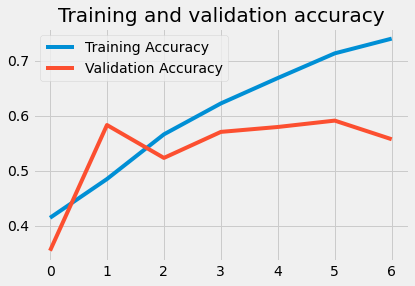

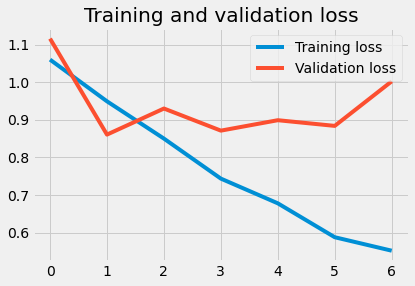

In [124]:
plot_performance(history)

In [125]:
evaluate(model, X_val_seq, y_val)

Loss: 0.8605
Categorical Accuracy: 0.5829
Cohens Kappa 0.2522
                                    precision    recall  f1-score   support

                  Negative emotion       0.21      0.45      0.29        71
No emotion toward brand or product       0.71      0.66      0.69       666
                  Positive emotion       0.52      0.48      0.50       385

                          accuracy                           0.58      1122
                         macro avg       0.48      0.53      0.49      1122
                      weighted avg       0.61      0.58      0.59      1122



## Iteration 6 - Smaller vocab

In [167]:
num_vocab = 3000

In [168]:
tokenizer = Tokenizer(num_words = num_vocab)
tokenizer.fit_on_texts(X_train)

In [169]:
# convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [170]:
# add padding
X_train_seq = pad_sequences(X_train_seq)
X_val_seq = pad_sequences(X_val_seq, maxlen=len(X_train_seq[0]))

In [171]:
max_len = len(X_train_seq[0])

In [172]:
# get embeddings for each word from the GloVe
word_emb_mat = np.zeros((num_vocab, 200))
for i in range(1, num_vocab):
    word = tokenizer.index_word[i]
    if word in glove_dict:
        word_emb_mat[i] = glove_dict[word]

In [199]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(Dropout(0.5))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(200, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = optimizers.Adam(learning_rate=0.01), 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [200]:
cb = EarlyStopping(monitor = 'val_loss', mode = 'min', 
                   verbose = 1, patience = 10, restore_best_weights = True)

start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                    class_weight=cw,
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 11s - loss: 1.0779 - categorical_accuracy: 0.4078 - val_loss: 0.9790 - val_categorical_accuracy: 0.5651
Epoch 2/100
141/141 - 7s - loss: 0.9752 - categorical_accuracy: 0.4804 - val_loss: 0.8454 - val_categorical_accuracy: 0.5722
Epoch 3/100
141/141 - 6s - loss: 0.8783 - categorical_accuracy: 0.5602 - val_loss: 1.0792 - val_categorical_accuracy: 0.5000
Epoch 4/100
141/141 - 7s - loss: 0.7864 - categorical_accuracy: 0.5934 - val_loss: 0.7921 - val_categorical_accuracy: 0.6301
Epoch 5/100
141/141 - 6s - loss: 0.7213 - categorical_accuracy: 0.6566 - val_loss: 0.9131 - val_categorical_accuracy: 0.5553
Epoch 6/100
141/141 - 6s - loss: 0.6935 - categorical_accuracy: 0.6638 - val_loss: 0.9067 - val_categorical_accuracy: 0.6043
Epoch 7/100
141/141 - 6s - loss: 0.6320 - categorical_accuracy: 0.7079 - val_loss: 1.0259 - val_categorical_accuracy: 0.5553
Epoch 8/100
141/141 - 5s - loss: 0.6097 - categorical_accuracy: 0.7103 - val_loss: 0.8804 - val_categorical_accuracy: 0.6096

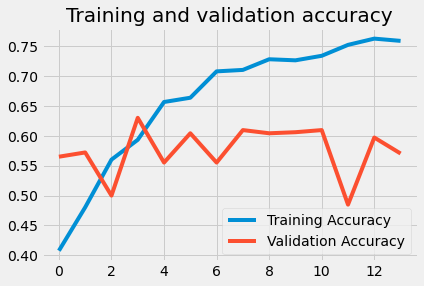

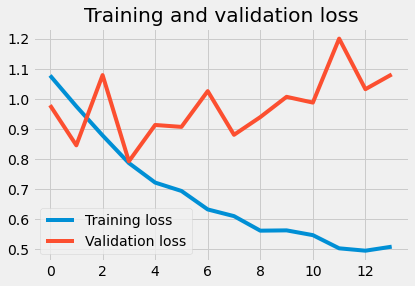

In [201]:
plot_performance(history)

In [202]:
evaluate(model, X_val_seq, y_val)

Loss: 0.7921
Categorical Accuracy: 0.6301
Cohens Kappa 0.2777
                                    precision    recall  f1-score   support

                  Negative emotion       0.27      0.24      0.25        71
No emotion toward brand or product       0.70      0.76      0.73       666
                  Positive emotion       0.54      0.48      0.51       385

                          accuracy                           0.63      1122
                         macro avg       0.50      0.49      0.50      1122
                      weighted avg       0.62      0.63      0.62      1122



## Final Test
I will get the result on the final model.

In [203]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 19, 200)           600000    
_________________________________________________________________
dropout_22 (Dropout)         (None, 19, 200)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_56 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_57 (Dense)             (None, 3)                 603       
Total params: 961,603
Trainable params: 961,603
Non-trainable params: 0
_________________________________________________________________


In [205]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = pad_sequences(X_test_seq, maxlen = len(X_train_seq[0]))
#y_test = pd.get_dummies(y_test).values

In [206]:
evaluate(model, X_test_seq, y_test)

Loss: 0.8243
Categorical Accuracy: 0.6336
Cohens Kappa 0.2854
                                    precision    recall  f1-score   support

                  Negative emotion       0.29      0.23      0.26        97
No emotion toward brand or product       0.70      0.76      0.73       832
                  Positive emotion       0.55      0.49      0.52       474

                          accuracy                           0.63      1403
                         macro avg       0.51      0.49      0.50      1403
                      weighted avg       0.62      0.63      0.63      1403

